# ResNet Model for Pneumonia Detection

## Import Needed Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Hyperparameters and Paths

In [2]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to data
TRAIN_DIR = "..\\..\\data\\chest_xray\\train"
VAL_DIR = "..\\..\\data\\chest_xray\\val"
TEST_DIR = "..\\..\\data\\chest_xray\\test"


# Data Transformations and Data Loaders

In [3]:
# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = ImageFolder(VAL_DIR, transform=val_transforms)
test_dataset = ImageFolder(TEST_DIR, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ResNet50 Model for Binary Classification

In [4]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

# Load a pre-trained ResNet model using the `weights` argument
weights = ResNet50_Weights.DEFAULT 
resnet = resnet50(weights=weights)

# Modify the fully connected layer for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),  # Binary classification (1 output neuron)
)

# Move the model to the GPU/CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet.to(DEVICE)


# Class Weights and Model Optimization

In [5]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
train_labels = np.array(train_dataset.targets)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Normal (0), Pneumonia (1)
    y=train_labels
)
class_weights = torch.tensor(class_weights).to(DEVICE)

# Define the weighted loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Apply weight to Pneumonia class

# Set optimizer to Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training and Validation Function with Performance Metrics

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None):
    # Track best running f1 score
    best_f1 = 0.0 
    # Track training losses
    train_losses = []  
    # Track validation losses
    val_losses = []    
    # Track validation accuracies
    val_accuracies = []  
    # Track precisions
    val_precisions = [] 
    # Track recalls 
    val_recalls = []  
    # Track F1-scores
    val_f1_scores = []  

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            # Weighted BCE Loss with class weights
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probs = torch.sigmoid(outputs)  # Convert logits to probabilities
                
                # Convert outputs to binary predictions
                preds = (probs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                # Collect predictions and labels for metrics
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1_scores.append(f1)

        # Print metrics for the current epoch
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
        

        # Save the best model based on F1-Score
        if f1 > best_f1:
            best_f1 = f1
            print("Model saved with best F1-Score!")
            torch.save(model.state_dict(), "best_model.pth")
        
        # Adjust learning rate
        if scheduler:
            scheduler.step(avg_val_loss)

    print(f"Training complete. Best F1-Score: {best_f1:.4f}")
    # Load saved weights
    model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
    model.eval()  # Set the model to evaluation mode
    print("Best model restored for evaluation.")
    return train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores


train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler
)

Epoch 1/10
Epoch [1/10] - Train Loss: 0.1376, Val Loss: 0.3942, Val Accuracy: 0.7500, Precision: 0.7000, Recall: 0.8750, F1-Score: 0.7778
Model saved with best F1-Score!
Epoch 2/10
Epoch [2/10] - Train Loss: 0.0910, Val Loss: 0.2935, Val Accuracy: 0.8750, Precision: 0.8750, Recall: 0.8750, F1-Score: 0.8750
Model saved with best F1-Score!
Epoch 3/10
Epoch [3/10] - Train Loss: 0.0697, Val Loss: 0.2160, Val Accuracy: 0.8750, Precision: 0.8000, Recall: 1.0000, F1-Score: 0.8889
Model saved with best F1-Score!
Epoch 4/10
Epoch [4/10] - Train Loss: 0.0762, Val Loss: 1.4918, Val Accuracy: 0.6250, Precision: 0.5714, Recall: 1.0000, F1-Score: 0.7273
Epoch 5/10
Epoch [5/10] - Train Loss: 0.0576, Val Loss: 0.8822, Val Accuracy: 0.5625, Precision: 0.5333, Recall: 1.0000, F1-Score: 0.6957
Epoch 6/10
Epoch [6/10] - Train Loss: 0.0570, Val Loss: 0.1739, Val Accuracy: 0.9375, Precision: 0.8889, Recall: 1.0000, F1-Score: 0.9412
Model saved with best F1-Score!
Epoch 7/10
Epoch [7/10] - Train Loss: 0.0594

C:\Users\David\AppData\Local\Temp\ipykernel_18920\4274305486.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loca

# Testing the Model on the Test Dataset

In [7]:
import torch.nn as nn

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    
    # Define the loss function (same as used during training)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Compute predictions and accuracy
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()      
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    # Calculate overall accuracy and average loss
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)
    
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Load the best model and test
model.load_state_dict(torch.load("best_model.pth"))
test_model(model, test_loader)


C:\Users\David\AppData\Local\Temp\ipykernel_18920\3944865815.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.4016, Test Accuracy: 0.8958


# Train v Validation Loss Graph

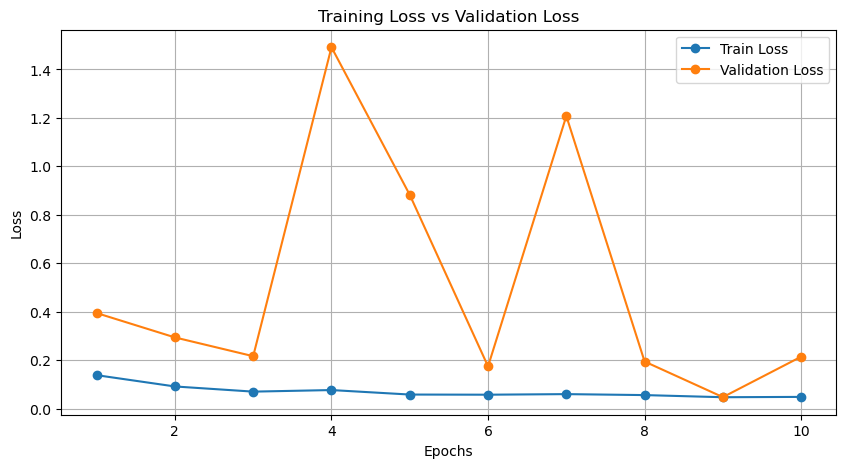

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
    
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid()
plt.show()


# ROC Curve (AuC) Graph

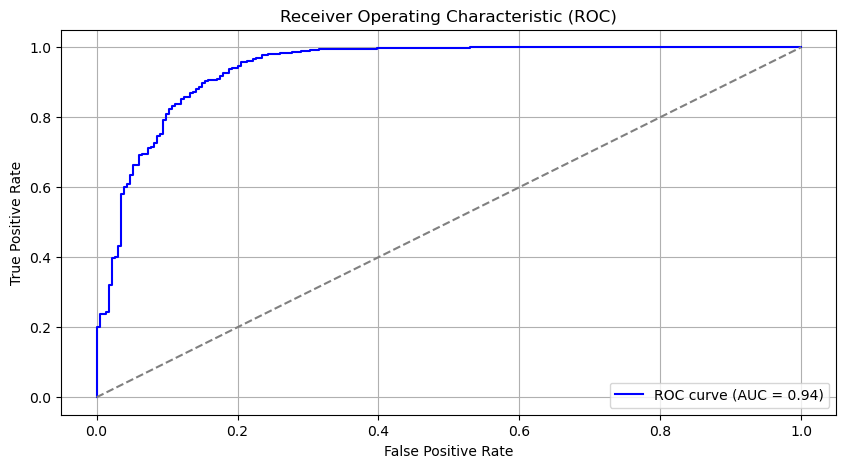

In [9]:
from sklearn.metrics import roc_curve, auc

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
# Compute ROC curve and AUC
false_postive_rate, true_positive_rate, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(false_postive_rate, true_positive_rate)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(false_postive_rate, true_positive_rate, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid()
plt.show()


# Confusion Matrix

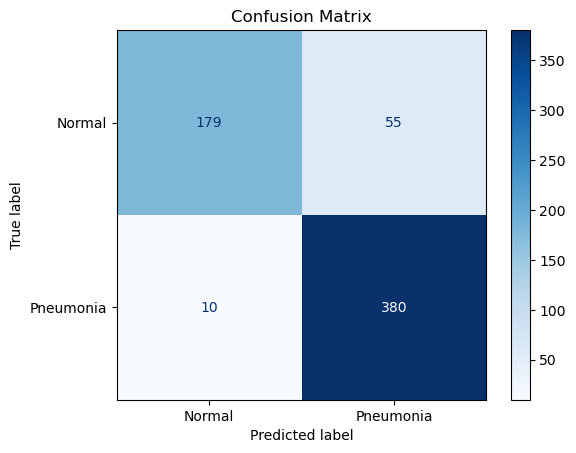

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_labels = []
all_preds = []
class_names = ["Normal", "Pneumonia"]

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Binary predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


# Metrics Over Epochs Graph (Accuracy, Precision, F1 Score)

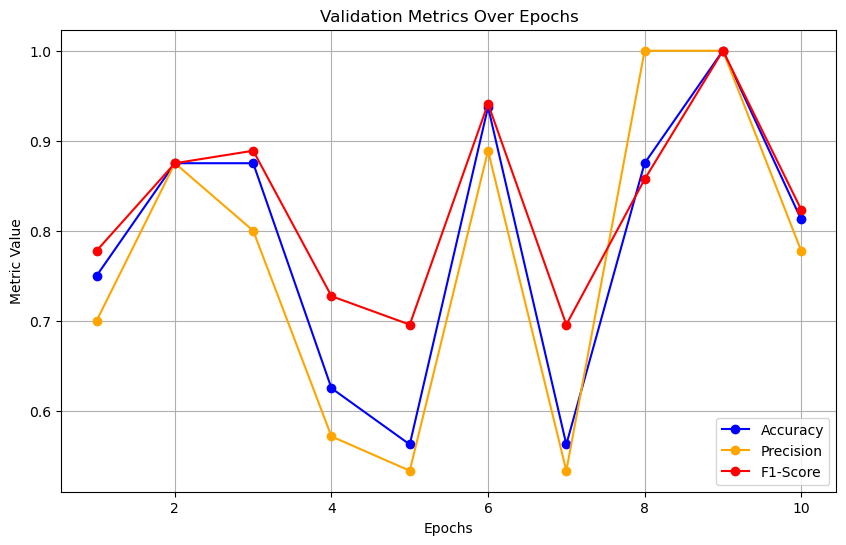

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label='Accuracy', marker='o', color='blue')
plt.plot(epochs, val_precisions, label='Precision', marker='o', color='orange')
plt.plot(epochs, val_f1_scores, label='F1-Score', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Validation Metrics Over Epochs')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()